In [1]:
%run data_cleaning.py

In [2]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = df_cleaned

In [5]:
df.dtypes
numerical_columns = [col for col in df.columns if col != "Tumor Size (mm)"]

In [6]:
from sklearn.preprocessing import RobustScaler

# Apllying RobustScaler to scale orginal numerical features
df[numerical_columns] = RobustScaler().fit_transform(df[numerical_columns])
df.head()

,Age,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size (mm),Estrogen Status,Progesterone Status,Regional Node Examined,Regional Node Positive,Survival Months,Status
0,1.000000,-1.0,0.0,-0.5,1.0,0.0,4,0.0,0.0,1.0,-0.333333,-0.516129,0.0
1,-0.285714,0.0,1.0,0.5,0.0,0.0,35,0.0,0.0,0.0,1.000000,-0.451613,0.0
2,0.285714,1.0,2.0,1.5,0.0,0.0,63,0.0,0.0,0.0,1.666667,-0.032258,0.0
3,0.285714,-1.0,0.0,-0.5,1.0,0.0,18,0.0,0.0,-1.2,-0.333333,0.258065,0.0
4,-0.500000,0.0,0.0,0.0,1.0,0.0,41,0.0,0.0,-1.1,-0.333333,-0.838710,0.0


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split #splitting data into test and train

model = LinearRegression()
X = df.drop(["Tumor Size (mm)", "T Stage", "6th Stage"], axis=1)
y = df["Tumor Size (mm)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

LinearRegression()

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
np.random.seed(42)

predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("Mean Squared Error:", str(mse) + " ((" + str(mse**0.5) + "))")
print("r2 Score:", str(r2))

Mean Squared Error: 195.15599520038026 ((13.969824451308623))
r2 Score: 0.0917372721904679


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE

In [10]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10.0, 100.0]}
scorer = make_scorer(mean_squared_error, greater_is_better=False)

#Adding Polynomial Features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

lasso = Lasso()
rfe = RFE(estimator=lasso)
X_train_selected = rfe.fit_transform(X_train_poly, y_train)
X_test_selected = rfe.transform(X_test_poly)

grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train_selected, y_train)

best_alpha = grid_search.best_params_['alpha']
best_lasso = Lasso(alpha=best_alpha)

best_lasso.fit(X_train_selected, y_train)

predictions = best_lasso.predict(X_test_selected)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error:", str(mse) + " ((" + str(mse**0.5) + "))")
print("r2 Score:", str(r2))

Mean Squared Error: 194.72966460326532 ((13.954557126733379))
r2 Score: 0.09372142948313367


In [11]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet()

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10.0, 100.0], 'l1_ratio': [0.1, 0.5, 0.7, 0.9]}

grid_search = GridSearchCV(estimator=ElasticNet(), param_grid=param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train_poly, y_train)

best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']
best_elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
best_elastic_net.fit(X_train_poly, y_train)

predictions = best_elastic_net.predict(X_test_poly)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error:", str(mse) + " ((" + str(mse**0.5) + "))")
print("r2 Score:", str(r2))

Mean Squared Error: 192.55623246901467 ((13.876463255059434))
r2 Score: 0.10383665754433924


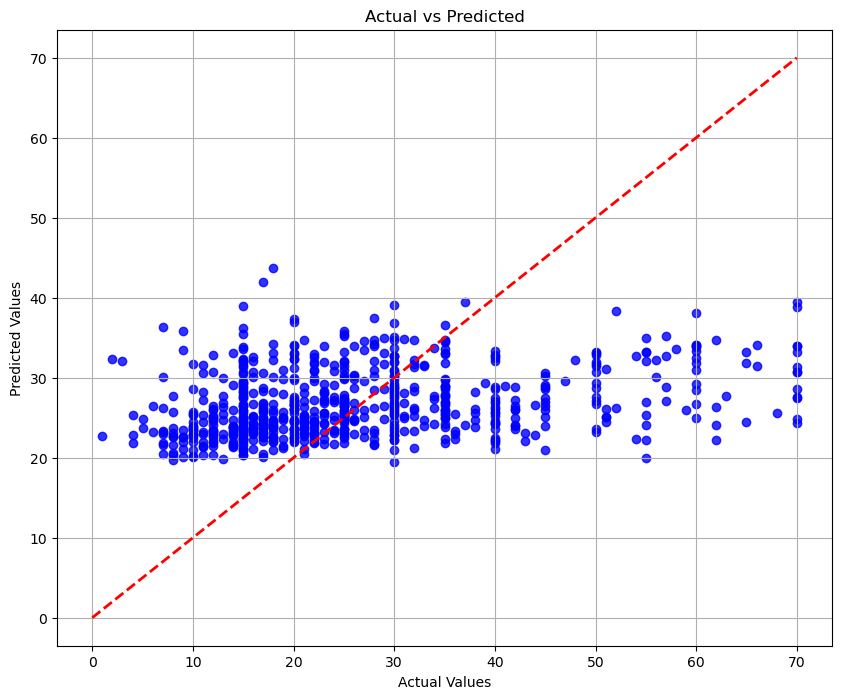

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, predictions, color='blue', alpha=0.8)
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--', linewidth=2)
plt.show()